Model to analyse the chosen ML regressor in terms of how the features contribute to its prediction

In [1]:
import numpy as np
import pandas as pd
import math
import joblib
import os

In [2]:
import custom_transformers
from importlib import reload
reload(custom_transformers)

<module 'custom_transformers' from 'C:\\Users\\giaco\\pcf-project\\ml_models\\custom_transformers.py'>

In [3]:
from custom_transformers import (
    TransformAdoptionFeatures,
    TransformCensusFeatures, 
    TransformClimateFeatures,
    TransformSoilFeatures,
    TransformEconomicFeatures,
)

In [4]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpeg", resolution=200):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
 # How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=10)

# Data ingestion

Same procedure as in the notebook for the ML models evaluation

In [7]:
path_to_dataset = "Municipalities final dataset for analysis.csv"

In [8]:
dataset_original = pd.read_csv(path_to_dataset, index_col=['Municipality', 'Year'])

In [9]:
mask_no_adoption = dataset_original['adoption_in_year'] < 0.0000001
dataset_original = dataset_original.drop(dataset_original.loc[mask_no_adoption].index)
len(dataset_original)

2466

In [10]:
# Remove outliers adoption_in_year
outliers = dataset_original.loc[dataset_original['adoption_in_year'] > 0.12].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([(    'Vagos', 2007),
            (    'Vagos', 2008),
            (    'Tomar', 2005),
            ('Alcochete', 2010),
            ('Alcochete', 2011),
            ('Alcochete', 2012)],
           names=['Municipality', 'Year'])


In [11]:
# Remove outliers cumul_adoption_10_y_pr_y_munic
outliers = dataset_original.loc[dataset_original['tot_cumul_adoption_pr_y_munic'] > 0.4].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([('Tomar', 2003),
            ('Tomar', 2004),
            ('Tomar', 2006),
            ('Tomar', 2007),
            ('Tomar', 2008)],
           names=['Municipality', 'Year'])


In [12]:
dataset_original.shape

(2455, 45)

In [13]:
dataset = dataset_original.reset_index(drop=True)

In [14]:
dataset.shape

(2455, 45)

## Copy the data splitting label and features

In [15]:
dataset_labels = dataset['adoption_in_year'].copy()
dataset = dataset.drop('adoption_in_year', axis=1)

In [16]:
dataset_labels.describe()

count   2455.000000
mean       0.004670
std        0.008587
min        0.000009
25%        0.000862
50%        0.002012
75%        0.004817
max        0.100604
Name: adoption_in_year, dtype: float64

## Original features names collection

In [17]:
features_original = [feat for feat in dataset.columns]

In [18]:
features_adoption = [feat for feat in features_original if 'adoption' in feat]
features_climate = [feat for feat in features_original if '_t_' in feat or '_prec_' in feat]
features_soil = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features_economic = ['sbp_payment']

features_not_census = (features_adoption + features_climate + features_soil + features_economic)
features_census = [feat for feat in features_original if feat not in features_not_census]

In [19]:
len(features_census) + len(features_not_census)

44

# Models analysis

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [21]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
import shap
from pdpbox import pdp, get_dataset, info_plots

In [22]:
ml_model = joblib.load('./Models to analyse/all_adoption/regressor/nl_svm.pkl')

In [23]:
model = Pipeline([
    ('scaling', StandardScaler()),
    ('estimator', ml_model)
])

### Dataset preparation

In [24]:
transformation_pipeline = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(), features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

In [25]:
dataset_prepared = transformation_pipeline.fit_transform(dataset)

In [26]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(), TransformCensusFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features = features + features_ind

In [27]:
len(features)

19

In [28]:
# Create dictionary to be able to get the index of the feature
features_idx = {}
for i, f in enumerate(features):
    features_idx[f] = i

### Stratified split

In [29]:
years = dataset_original.index.get_level_values(1).to_list()
train_X, val_X, train_y, val_y = train_test_split(dataset_prepared, dataset_labels, stratify=years, random_state=42)

In [30]:
model.fit(train_X, train_y)

Pipeline(steps=[('scaling', StandardScaler()),
                ('estimator',
                 SVR(C=0.14784953519746086, degree=2,
                     epsilon=0.0016058809956497162,
                     gamma=0.025548599370524356))])

### Permutation importance

In [106]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)

In [107]:
eli5.show_weights(perm, feature_names = features)

Weight,Feature
0.9611 ± 0.0592,tot_cumul_adoption_pr_y_munic
0.1883 ± 0.0449,tot_cumul_adoption_pr_y_port
0.1880 ± 0.0319,sbp_payment
0.1581 ± 0.0259,pastures_area_var
0.1044 ± 0.0328,educ_second_super
0.0708 ± 0.0315,av_d_max_t_average_munic
0.0676 ± 0.0128,CN_mean_munic
0.0591 ± 0.0403,cons_days_no_prec_average_munic
0.0451 ± 0.0274,inc_mainly_ext
0.0406 ± 0.0098,av_d_mean_t_average_munic


### SHAP values

In [31]:
import pickle
filename = './Model analysis shap values/regressor_all_adoption_shapvalues.sav'

In [33]:
explainer = shap.KernelExplainer(model.predict, shap.kmeans(train_X, 100))

In [114]:
# Calculate shap_values for all of val_X
shap_values = explainer.shap_values(val_X)

In [115]:
# Save shap values
pickle.dump(shap_values, open(filename, 'wb'))

In [32]:
# Load shapvalues
shap_values = pickle.load(open(filename, 'rb'))

Saving figure shap_regressor_all_adoption


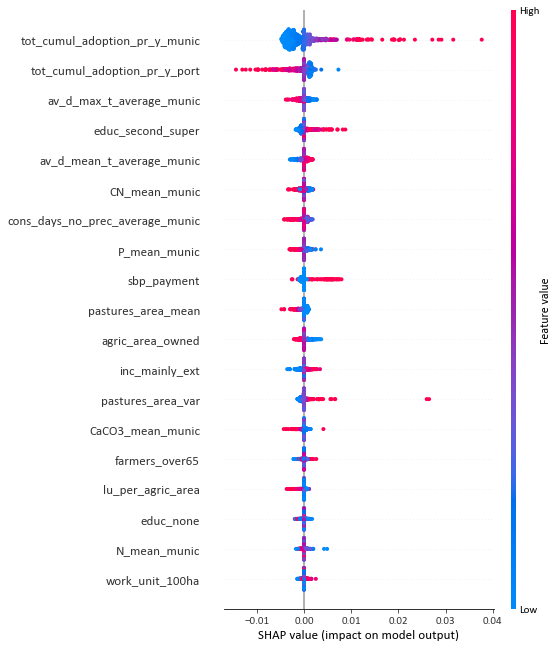

In [42]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, val_X, feature_names=features, max_display=len(features), show=False)
f = plt.gcf()
save_fig(('shap_regressor_all_adoption'), tight_layout=True)

Saving figure regressor_cumul_adoption_munic_port


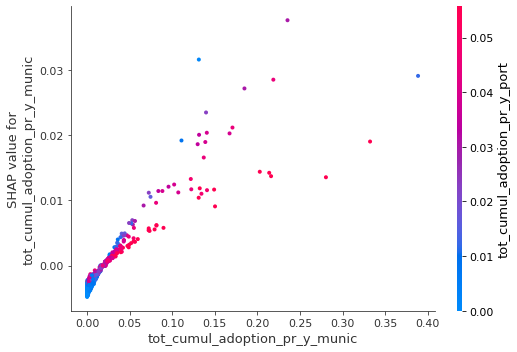

In [35]:
feat_to_plot = 'tot_cumul_adoption_pr_y_munic'
feat_interact = 'tot_cumul_adoption_pr_y_port'
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
save_fig('regressor_cumul_adoption_munic_port', tight_layout=True)

Saving figure regressor_cumul_adoption_munic


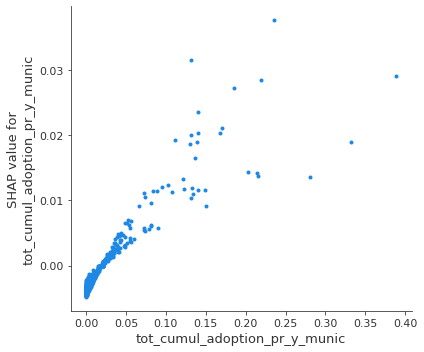

In [129]:
feat_to_plot = 'tot_cumul_adoption_pr_y_munic'
feat_interact = None
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
fig = plt.gcf()
save_fig('regressor_cumul_adoption_munic', tight_layout=True)

Saving figure regressor_cumul_adoption_port_munic


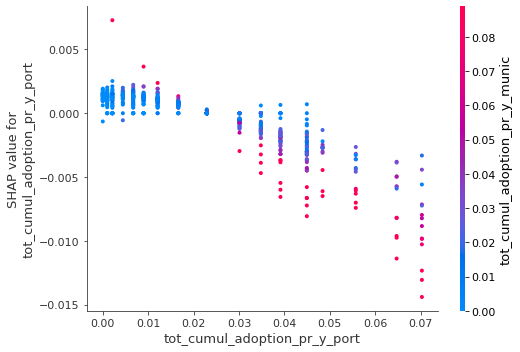

In [36]:
feat_to_plot = 'tot_cumul_adoption_pr_y_port'
feat_interact = 'auto'
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
fig = plt.gcf()
save_fig('regressor_cumul_adoption_port_munic', tight_layout=True)

Saving figure regressor_cumul_adoption_port


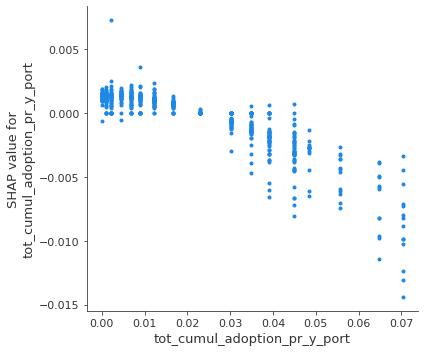

In [131]:
feat_to_plot = 'tot_cumul_adoption_pr_y_port'
feat_interact = None
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
fig = plt.gcf()
save_fig('regressor_cumul_adoption_port', tight_layout=True)

Saving figure regressor_payments


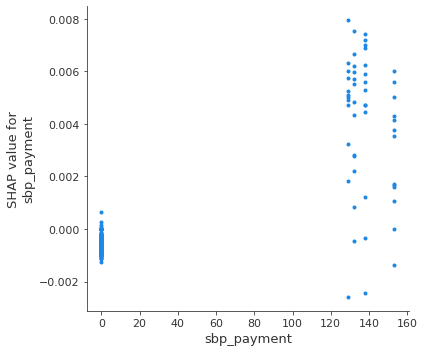

In [37]:
feat_to_plot = 'sbp_payment'
feat_interact = None
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
fig = plt.gcf()
save_fig('regressor_payments', tight_layout=True)

Saving figure regressor_educ_payments


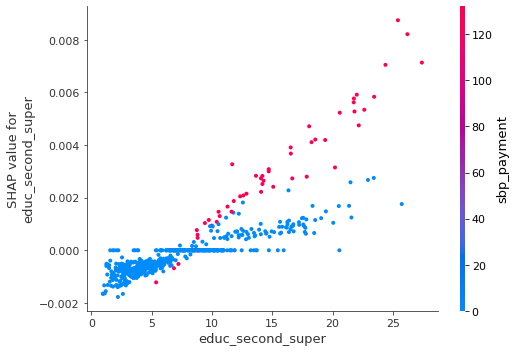

In [38]:
feat_to_plot = 'educ_second_super'
feat_interact = 'auto'
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
fig = plt.gcf()
save_fig('regressor_educ_payments', tight_layout=True)

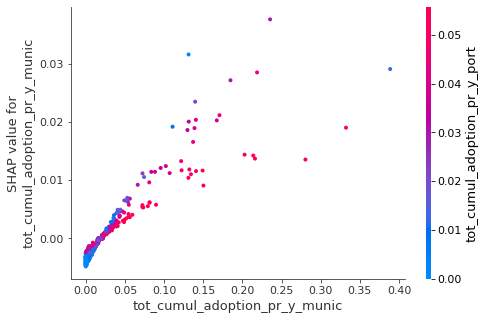

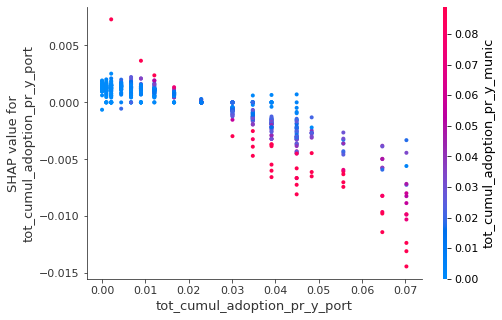

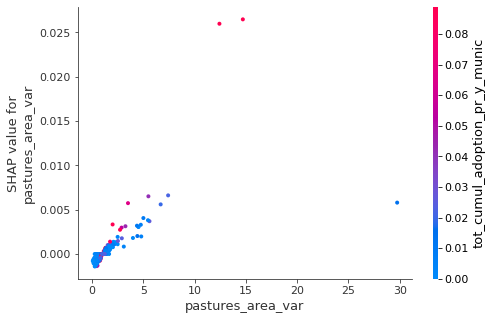

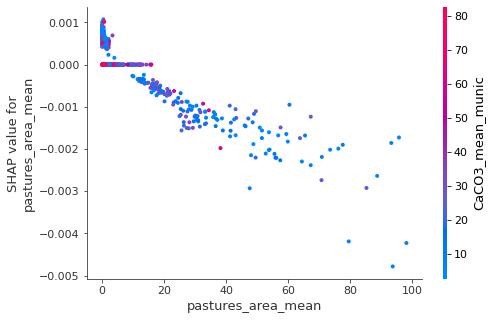

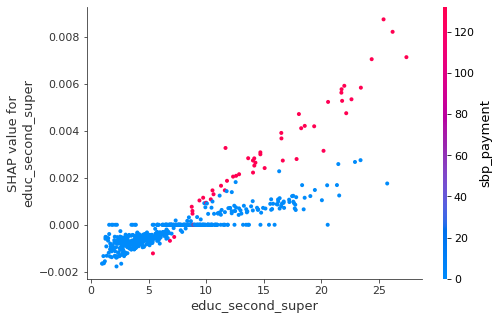

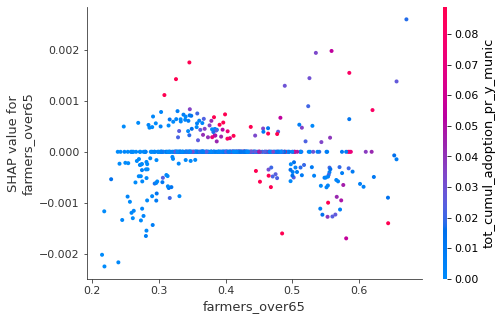

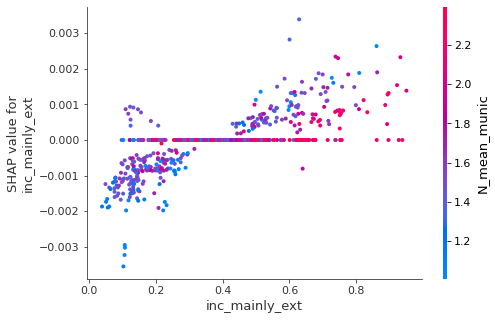

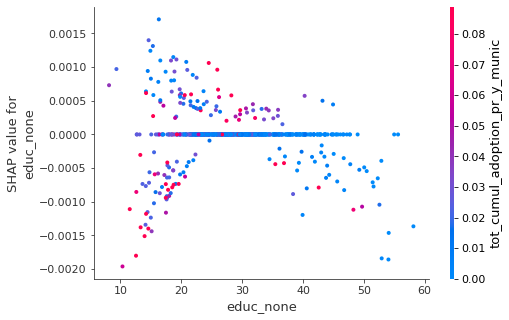

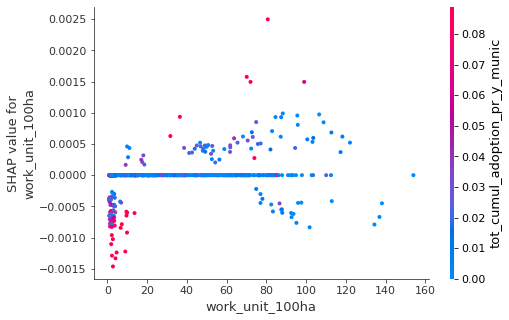

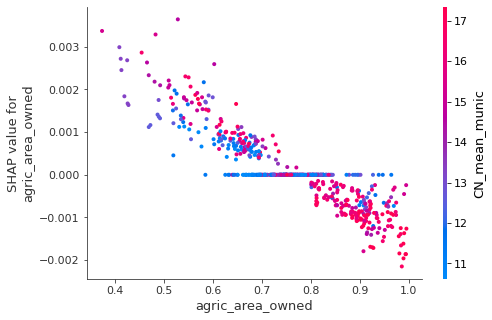

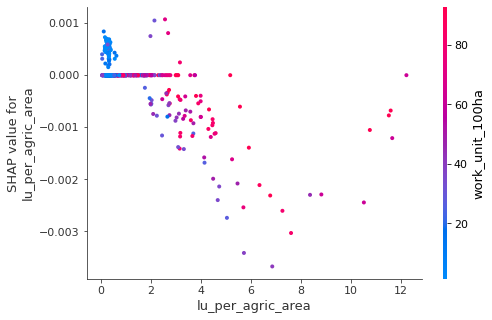

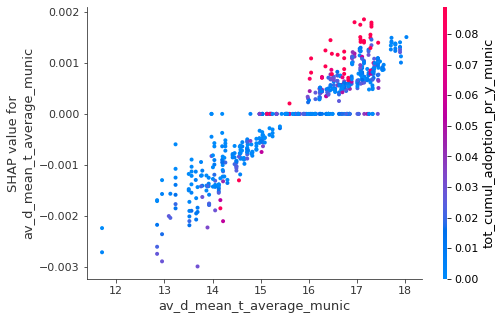

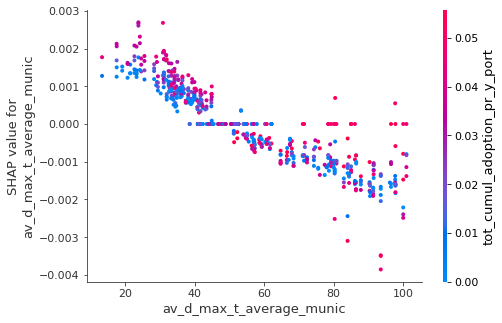

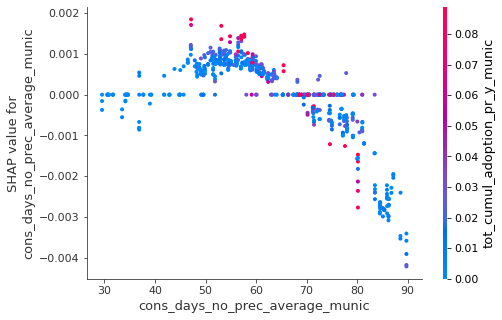

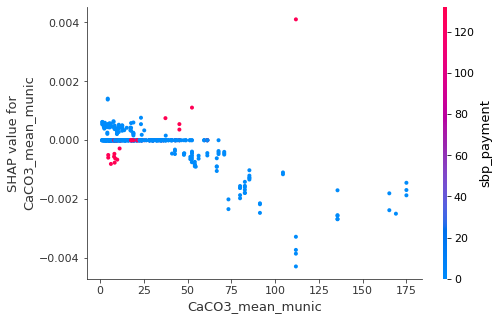

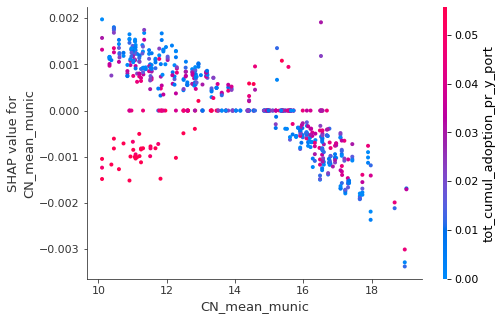

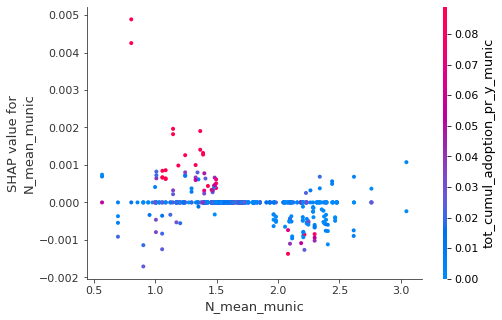

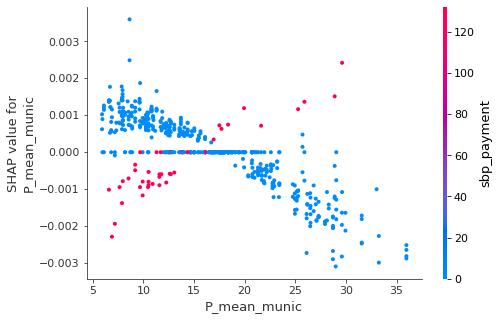

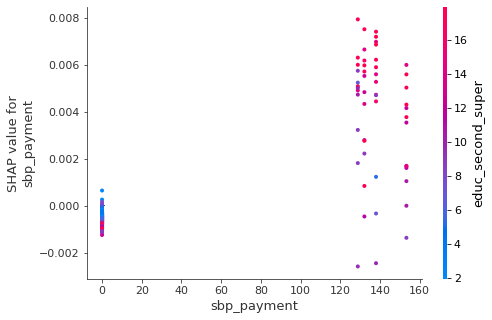

In [34]:
for feat in features:
    feat_to_plot = feat
    feat_interact = 'auto'
    shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                         interaction_index=feat_interact, show=False)